### MELD

In this notebook we'll merge results from the two techniques used to collect metadata from the phot archive

- **metadata** extraction with exiftool
- **ocr** with tessaract

We'll discuss what we obtained and we'll eventually merge the data to obtain the final dataset

In [20]:
import os
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import re
import numpy as np

In [21]:
# defining the directories
image_directory = '../images/aculei-images'
datasets_directory = '../datasets'

In [22]:
df_ocr = pd.read_csv(f'{datasets_directory}/ocr.csv', index_col=0)
df_metadata = pd.read_csv(f'{datasets_directory}/metadata.csv', index_col=0)

In [23]:
print('Null values before OCR')
print(df_metadata.isnull().sum())

Null values before OCR
hash             0
image_name       0
camera        4452
date_time      103
date           103
time           103
moon           103
dtype: int64


In [24]:
print('Null values after OCR')
print(df_ocr.isnull().sum())

Null values after OCR
hash             0
image_name       0
camera         537
date_time      103
date            12
time            12
moon           103
temp          6417
dtype: int64


In [25]:
print(len(df_ocr))
print(len(df_ocr['hash'].unique()))


16874
8270


First thing first: compute the hash of the images to have a unique identifier. The previous calculated hash was not unique because it was a 'similarity image hash'.

In [26]:
# def sha256sum(filename):
#     h = hashlib.sha256()
#     b = bytearray(128 * 1024)
#     mv = memoryview(b)
#     with open(filename, 'rb', buffering=0) as f:
#         while n := f.readinto(mv):
#             h.update(mv[:n])
#     return h.hexdigest()

# def compute_sha256(filename):
#     image_path = os.path.join(image_directory, filename)
#     return sha256sum(image_path)

# # add 'sha-256' column to the DataFrame
# tqdm.pandas(desc="Computing SHA-256", unit="files")
# df_ocr['sha-256'] = df_metadata['image_name'].progress_apply(compute_sha256)


In [27]:
# print(len(df_ocr))
# print(len(df_ocr['sha-256'].unique()))

Now we obtained a real unique hash so we can drop the previous column 'hash'

In [28]:
df_ocr.drop('hash', axis=1, inplace=True)

In [29]:
df_ocr.sample(5)

,image_name,camera,date_time,date,time,moon,temp
12705,TF_ACULEI_8462_DSCF0532.jpg,CAM_1,2021-07-25 01:00:23,2021-07-25,01:00:23,Full Moon,24°C
9285,TF_ACULEI_94_DSCF0204.jpg,CAM7,2021-01-22 02:23:11,2021-01-22,02:23:11,First Quarter,14°C
15904,TF_ACULEI_11426_DSCF0043.jpg,CAM_5,2022-06-17 01:39:38,2022-06-17,01:39:38,Waning Gibbous,20°C
4753,TF_ACULEI_16217_DSCF0164.jpg,CAM4,2023-06-24 22:46:30,2023-06-24,22:46:30,First Quarter,18°C
13735,TF_ACULEI_15489_DSCF0169.jpg,CAM4,2023-04-11 23:28:08,2023-04-11,23:28:08,Last Quarter,9°C


We have to check the results obtained with ocr and metadata combined

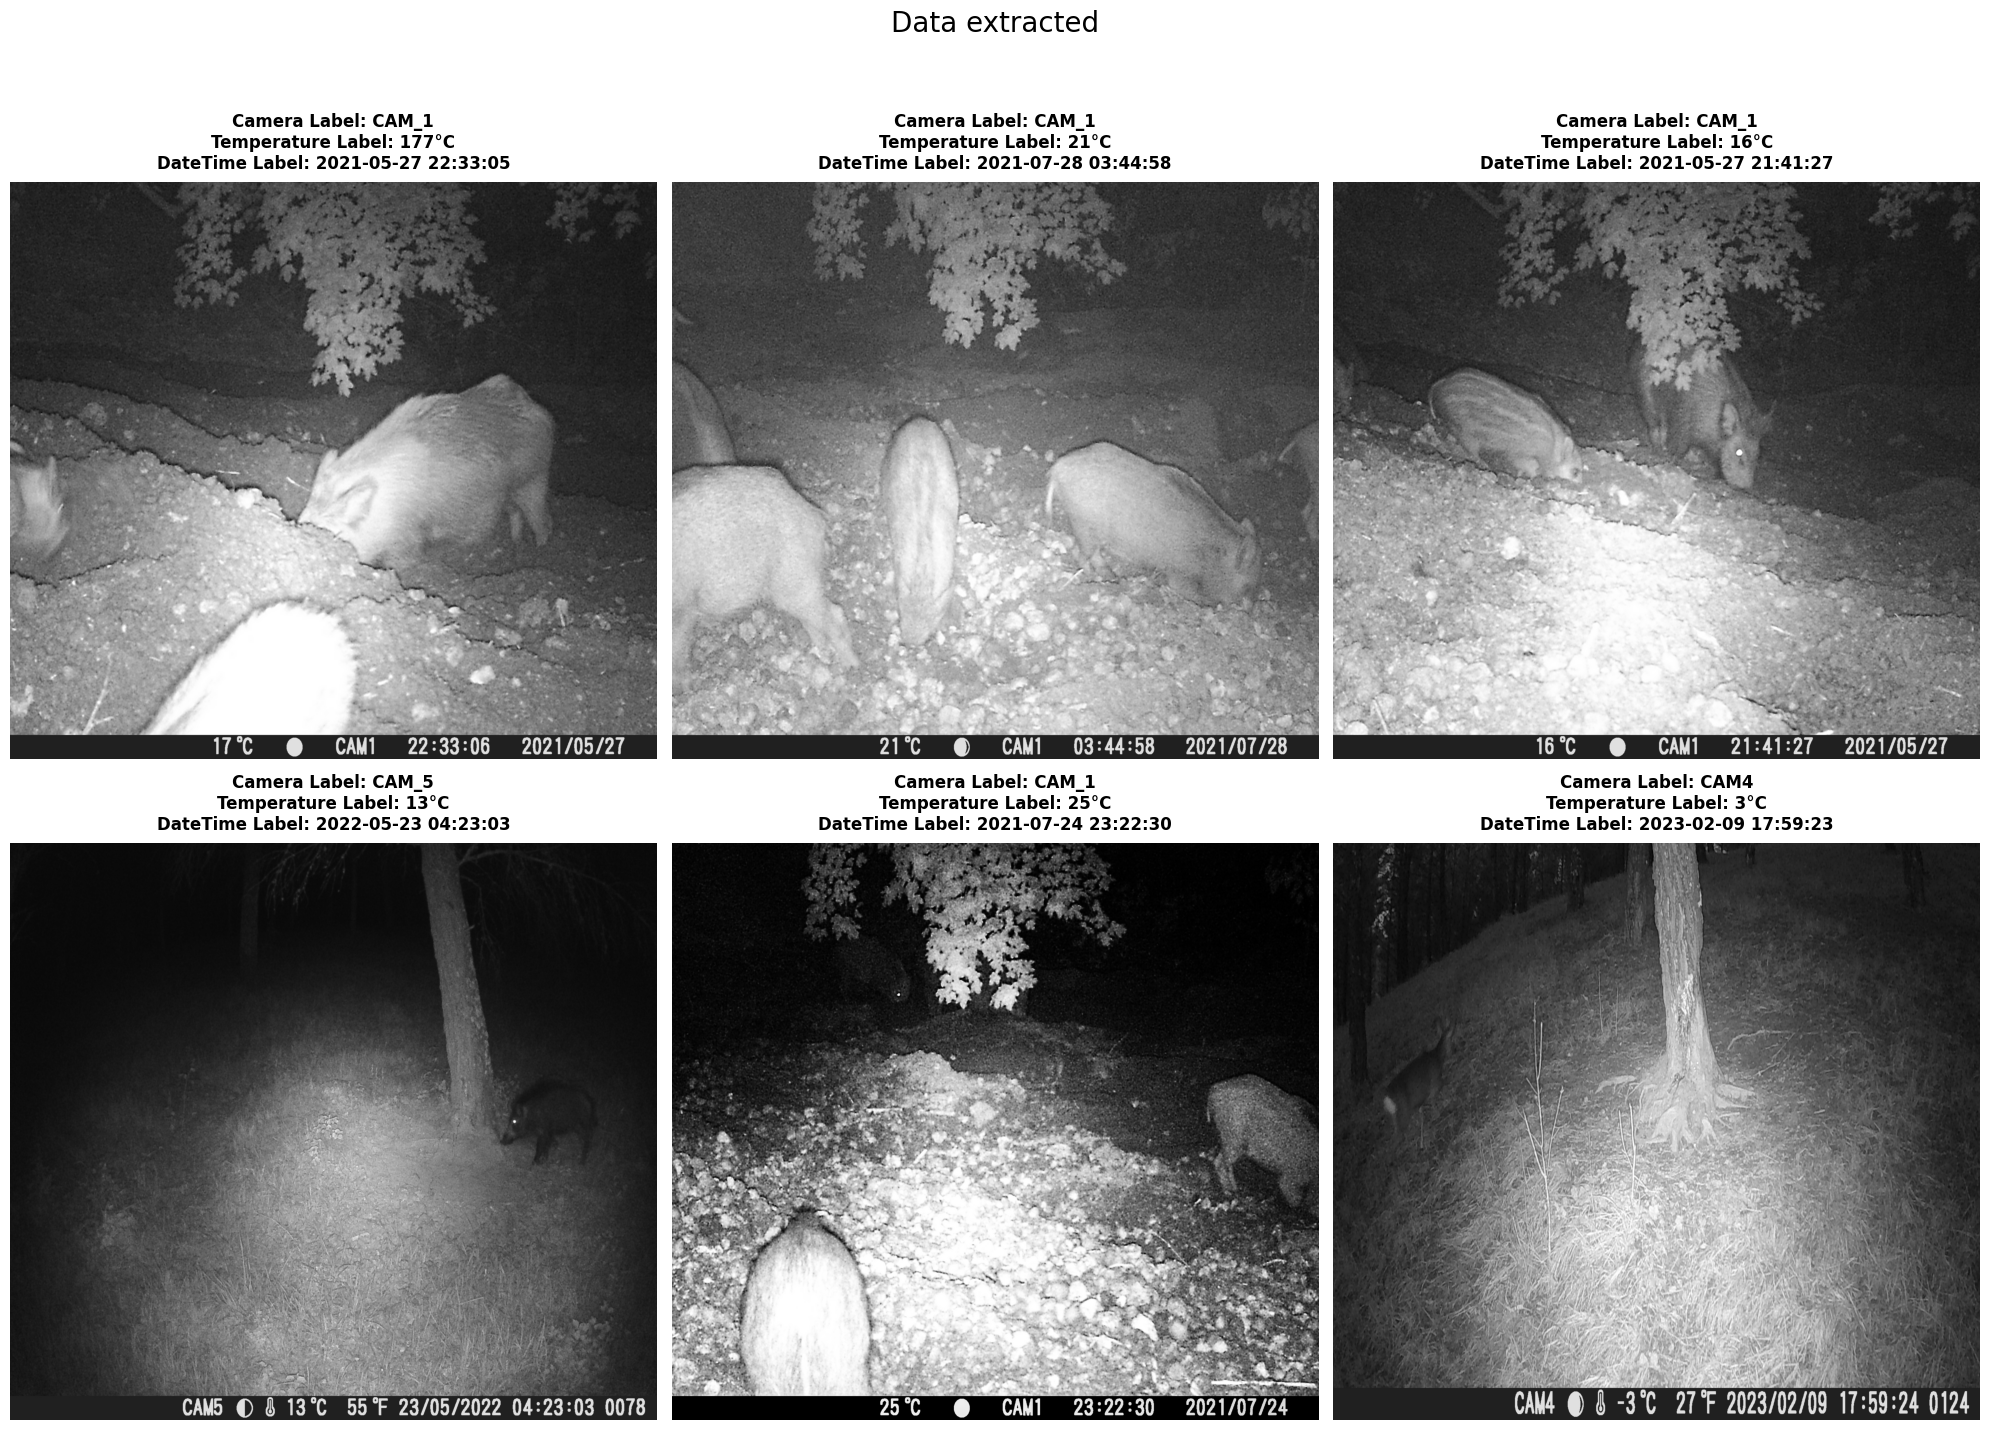

In [30]:
valid_rows = df_ocr.dropna(subset=['camera', 'temp', 'date_time'])
six_random_rows = valid_rows.sample(n=6, random_state=random.seed())

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle('Data extracted', fontsize=20)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    
for i, ax in enumerate(axes):
    image_path = os.path.join(image_directory, six_random_rows.iloc[i]['image_name'])
    image = Image.open(image_path)
    ax.imshow(image, aspect='auto')
    ax.axis('off')

    camera_info = six_random_rows.iloc[i]['camera']
    date_time_info = six_random_rows.iloc[i]['date_time']
    temp_info = six_random_rows.iloc[i]['temp'] 
    title_text = f"Camera Label: {camera_info}\nTemperature Label: {temp_info}\nDateTime Label: {date_time_info}"
    ax.set_title(title_text, fontsize=12, fontweight='bold', pad=10)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

It seems that some errors happened setting the date_time column from ocr process. So we extracts the rows where date and time are not null and we set the date_time column combining those two

In [31]:
filtered_rows = df_ocr[(df_ocr['date_time'].isnull()) & (~df_ocr['date'].isnull()) & (~df_ocr['time'].isnull())]

df_ocr.loc[filtered_rows.index, 'date_time'] = pd.to_datetime(filtered_rows['date'] + ' ' + filtered_rows['time'])

Now let's fill the moon column

In [32]:
from moon_phase import phase

# extract moon phase
df_ocr['date_time'] = pd.to_datetime(df_ocr['date_time'])
df_ocr['moon'] = df_ocr['date_time'].apply(lambda x: phase(str(x)) if not pd.isnull(x) else None)

In [33]:
df_ocr.isnull().sum()

image_name       0
camera         537
date_time       12
date            12
time            12
moon            12
temp          6417
dtype: int64

We are almost there! we have to check some more thing and we're done:

- ocr camera results
- ocr temperature results
- ocr date_time results

To do that we'll check giving some ranges for example: we know that there are **7 cameras** and they are labelled as CAM_*N* where *N* is a number between 1 to 7. So if we find a different case we have to drop/modify that entry.


In [34]:
df_ocr['camera'].value_counts()

CAM_1    9076
CAM4     1716
CAME     1194
CAM_4    1047
CAM_3     995
CAM_5     671
CAMS      328
CAM_6     247
CAM_7     198
CAM_2     188
CAM7      159
CAM5      140
CAM?      131
CAMEO      74
CAM6       42
CAMG       18
CAM        16
CAMA       11
CAMT       10
CAM.       10
CAM7Z       8
CANT        8
CAMB        7
CANE        5
CAMG6       5
CANG        4
CA          3
CAMZ        2
CAME6       2
CAM7T       2
CAM6-       2
CAML        1
CANS        1
CAMS:       1
CAEN,       1
CAME”       1
CARS        1
CAA         1
CAN5-       1
CAMD        1
CAN5        1
CAG         1
CAM/        1
CAND        1
CAMG.       1
CAN6        1
CAM4.       1
CAE         1
CAMG-       1
Name: camera, dtype: int64

Well ocr was cool but not that cool we have to tackle this

Entries like CAM7 have to be replaced with CAM_7 (putting the underscore)

We noticed also that CAME has a lot of entries so we have to investigate what the ocr have done

In [35]:
valid_rows = df_ocr[df_ocr['camera'] == 'CAME']
nine_random_rows = valid_rows.sample(n=9, random_state=random.seed())

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), ((ax7, ax8, ax9))) = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Data extracted', fontsize=20)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
    
for i, ax in enumerate(axes):
    image_path = os.path.join(image_directory, nine_random_rows.iloc[i]['image_name'])
    image = Image.open(image_path)
    ax.imshow(image, aspect='auto')
    ax.axis('off')

    camera_info = nine_random_rows.iloc[i]['camera']
    title_text = f"Camera Label: {camera_info}"
    ax.set_title(title_text, fontsize=12, fontweight='bold', pad=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

It seems that the ocr recognized CAM6 as CAME

Interesting we'll replace trusting those samples

In [ ]:
valid_cameras = [f"CAM_{i}" for i in range(1, 8)]

def process_camera(camera):
    if pd.notnull(camera):
        # replace 'CAME' with 'CAM6'
        if camera == 'CAME':
            return 'CAM_6'

        # using regular expression to match 'CAM' followed by any number from 1 to 7
        pattern = r'CAM(\d)'
        match = re.match(pattern, camera)
        if match:
            # replace the matched pattern with 'CAM_{number}'
            modified_camera = f"CAM_{match.group(1)}"
            if modified_camera in valid_cameras:
                return modified_camera
    return camera  # return the original value if it's not valid

df_ocr['camera'] = df_ocr['camera'].apply(process_camera)
df_ocr.loc[~df_ocr['camera'].isin(valid_cameras), 'camera'] = np.nan

In [ ]:
df_ocr['camera'].value_counts()

CAM_1    9076
CAM_4    2764
CAM_6    1485
CAM_3     995
CAM_5     811
CAM_7     367
CAM_2     188
Name: camera, dtype: int64

In [ ]:
df = df_ocr.copy()
df.to_csv(datasets_directory + '/aculei.csv')